

# Data Description:

https://olympus.greatlearning.in/courses/40612/files/4168350?module_item_id=1976416

You are provided with a dataset of images of plant seedlings at various stages of grown. Each image has a filename that is its
unique id. The dataset comprises 12 plant species. The goal of the project is to create a classifier capable of determining a
plant's species from a photo.


Link to the Kaggle project site: https://www.kaggle.com/c/plant-seedlings-classification/data?select=train

# Context:

Can you differentiate a weed from a crop seedling?
The ability to do so effectively can mean better crop yields and better stewardship of the environment.
The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has
recently released a dataset containing images of unique plants belonging to 12 species at several growth stages

In [ ]:
# Get the data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Overview of data

In [ ]:
# import standard libraries as per MLS2 Session example Brain Tumor problem

#Reading the training images from the path and labelling them into the given categories
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns # for data visualization 
import tensorflow as tf
import keras
from sklearn.preprocessing import LabelEncoder
#ignoring warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.models import Sequential #sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten #importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU,Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical #to perform one-hot encoding 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam #optimiers for optimizing the model
from keras.callbacks import EarlyStopping  #regularization method to prevent the overfitting
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import losses, optimizers

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)

# to suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Load data and exploration

In [ ]:
image = np.load('/content/drive/MyDrive/Colab Notebooks/intro_to_compute_vision/project/images.npy')
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/intro_to_compute_vision/project/Labels.csv')

In [ ]:
image.shape


(4750, 128, 128, 3)

### Observation
 -4750 images with size 128x128 RGB (3 Channels).



In [ ]:
print(labels.nunique())
labels.value_counts()

Label    12
dtype: int64


Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
dtype: int64

### Observations
- DS don't have equal representation of all the classes of plant seedlings



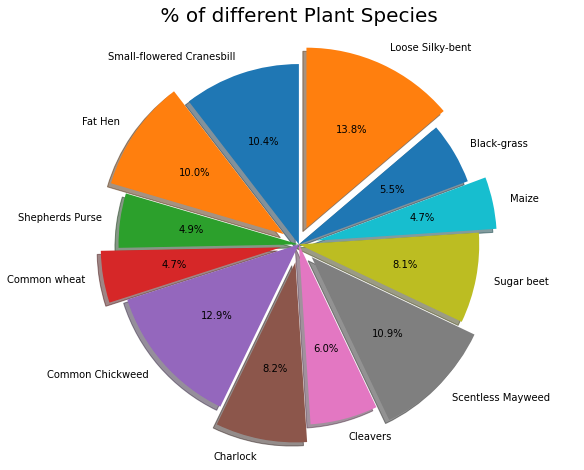

In [ ]:
#plotting the pie chart 
lbls = ['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse', 'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers', 'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass', 'Loose Silky-bent']
count = []
for i in lbls:
    count.append(labels.Label[labels['Label'] == i ].count())
explode = (0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1, 0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(count, explode = explode, labels=lbls, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title(" % of different Plant Species ", size = 20)
plt.show()

### Observations

- Silky bent have max samples ~ 14%
- Good representation of weeds (Common Chickweed, Scentless Mayweed) in image dataset.

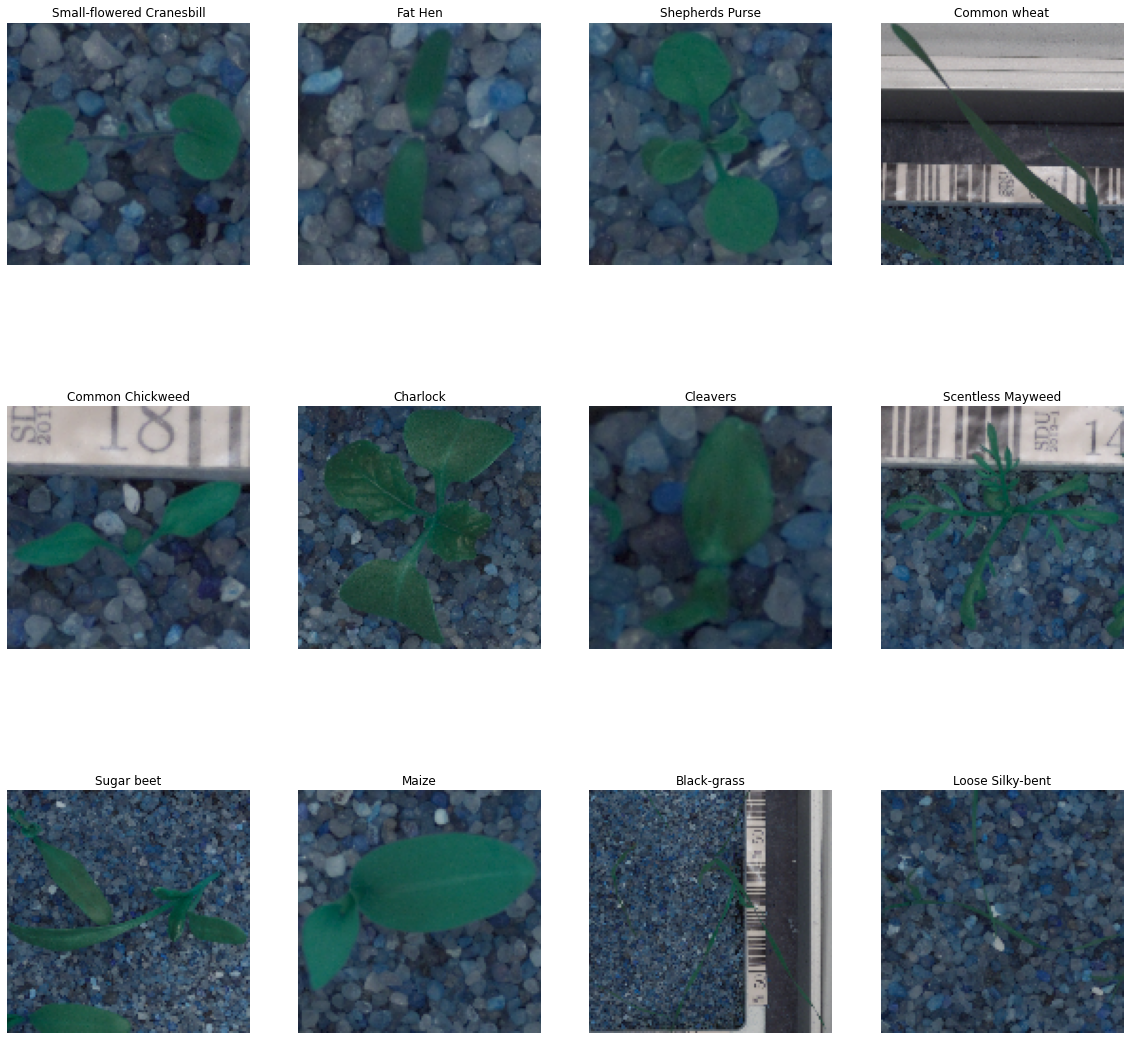

In [ ]:
# Images from each class and their corresponding labels

data = [[image[i],labels.iloc[i].values[0]] for i in range(len(labels))]
df = pd.DataFrame(data)
class_names = labels['Label'].unique().tolist()

plt.figure(figsize=(20,20))
for i,class_name in enumerate(class_names):
    for img, label in df[df[1]==class_name].head(1).values.tolist():
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

### Observations
- Black grass and silky bent seem to be tough to distinguish ... Need to take care of it later in the modelling.

# EDA

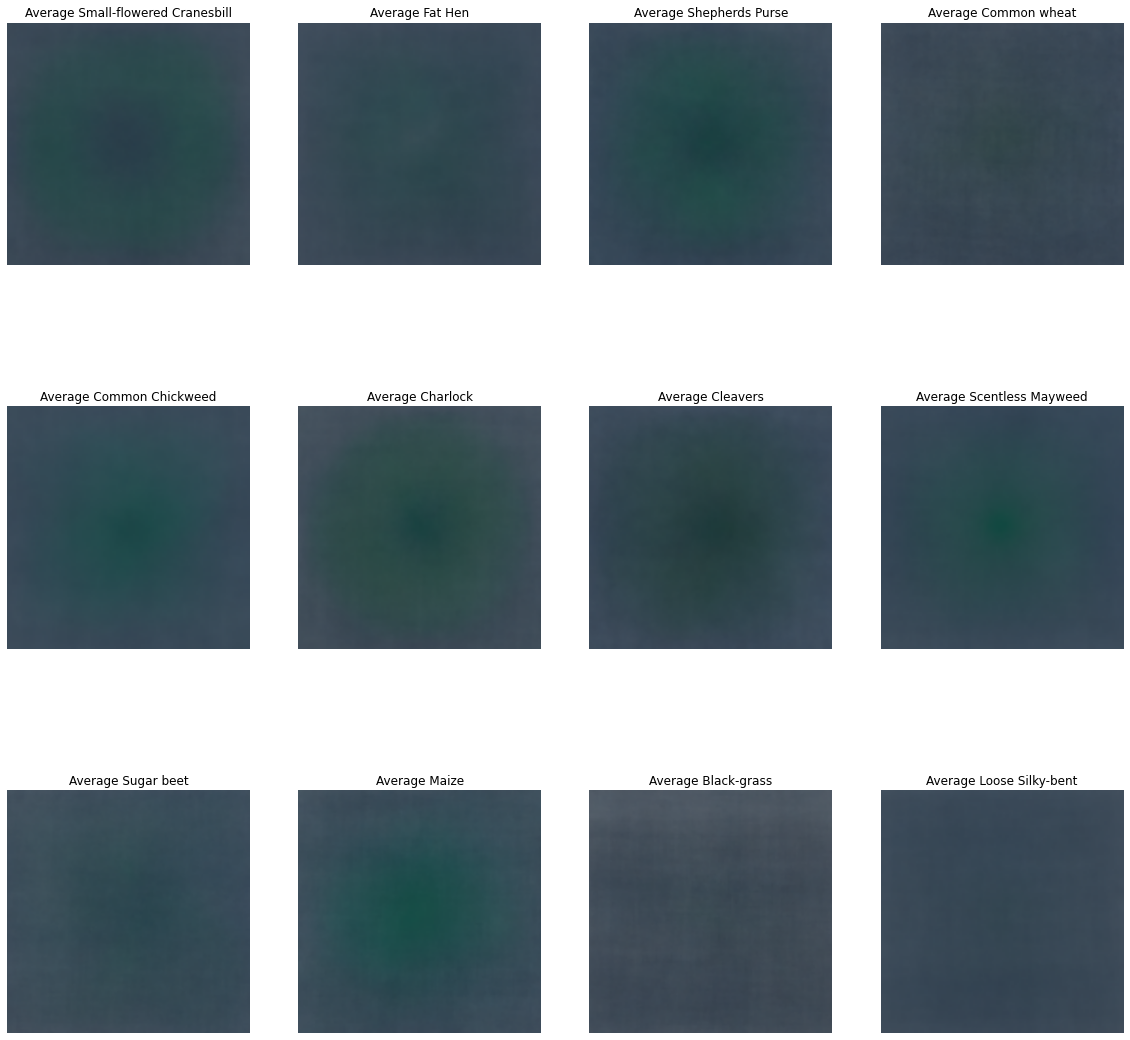

In [ ]:
# Mean images of each class 
plt.figure(figsize=(20,20))
for i,class_name in enumerate(class_names):
    # calculate the average
    mean_img = np.mean(np.array((df[df[1]==class_name][0]).values.tolist()), axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((128,128,3)).astype(np.uint8)
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(mean_img)
    plt.title(f'Average {class_name}')
    plt.axis('off')

### Observations
- Black Grass, Loose Silky there is good differentiation for green weed
- Small-flowered cranesbill, Shepherds Purse have more wide green weed

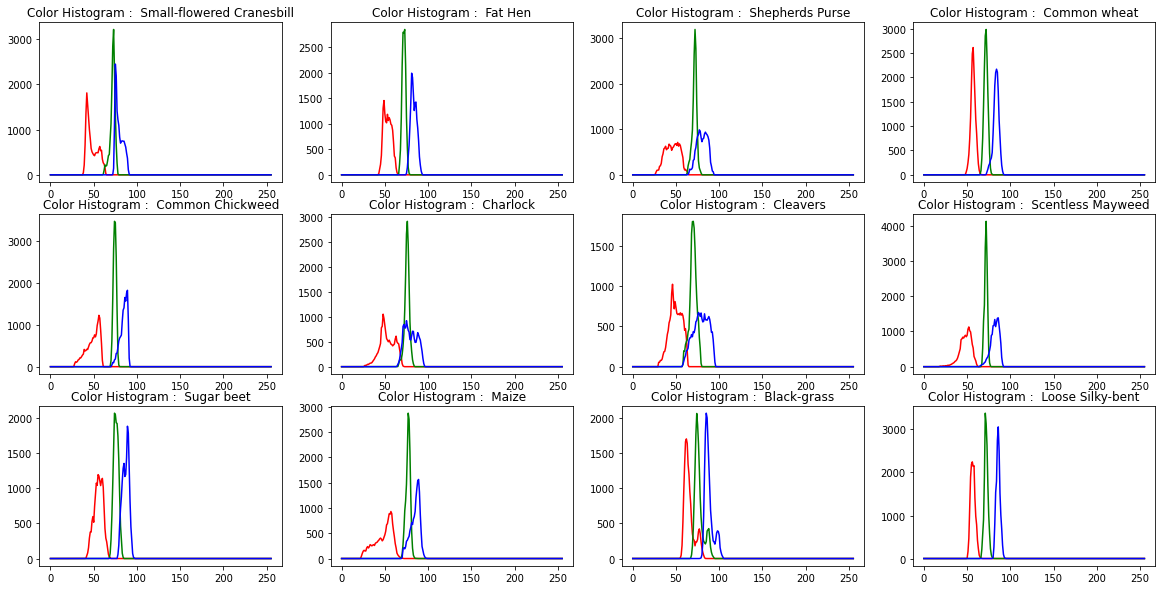

In [ ]:
colors = ("red", "green", "blue")
channel_ids = (0, 1, 2)
plt.figure(figsize=(20,10))
# create the histogram plot, with three lines, one for
# each color

ax = plt.subplot(3, 4, i+1)

for i,class_name in enumerate(class_names):
    # calculate the average
    mean_img = np.mean(np.array((df[df[1]==class_name][0]).values.tolist()), axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape((128,128,3)).astype(np.uint8)
    ax = plt.subplot(3, 4, i+1)
    for channel_id, c in zip(channel_ids, colors):
        histogram, bin_edges = np.histogram(
            mean_img[:, :, channel_id], bins=256, range=(0, 256)
        )
        ax.plot(bin_edges[0:-1], histogram, color=c)
        plt.title(f'Color Histogram :  {class_name}')

### Observations
- the RGB distribution matches with what I inferred in the mean plot. Small flowered and shephers purse have more more green differentation


# EDA Conclusions

- 4750 samplles with 128x128 with 3 channels (RGB)
- DS don't equal representation in all classes
- Sikly bent is max samples c.f to other samples. More overfitting in the model - need to account for that
- black grasss and sikly bent seems to be difficult to differentiate


In [ ]:
# Data Pre-processing

In [ ]:
# remove the noise using cv2 Gaussian blurring
blurred_img = [cv2.GaussianBlur(image[i],(5,5),0) for i in range(len(image))] 

In [ ]:
#normalization - as per MLS session
blurred_img_norm = np.array(blurred_img)/255.0 

In [ ]:
#gray image
gray_img = [cv2.cvtColor(image[i],cv2.COLOR_BGR2GRAY) for i in range(len(image))]
blurred_gray_img = [cv2.blur(gray_img[i],(5,5)) for i in range(len(image))] 
blurred_gray_norm = np.array(blurred_gray_img)/255.0

image before pre-processing


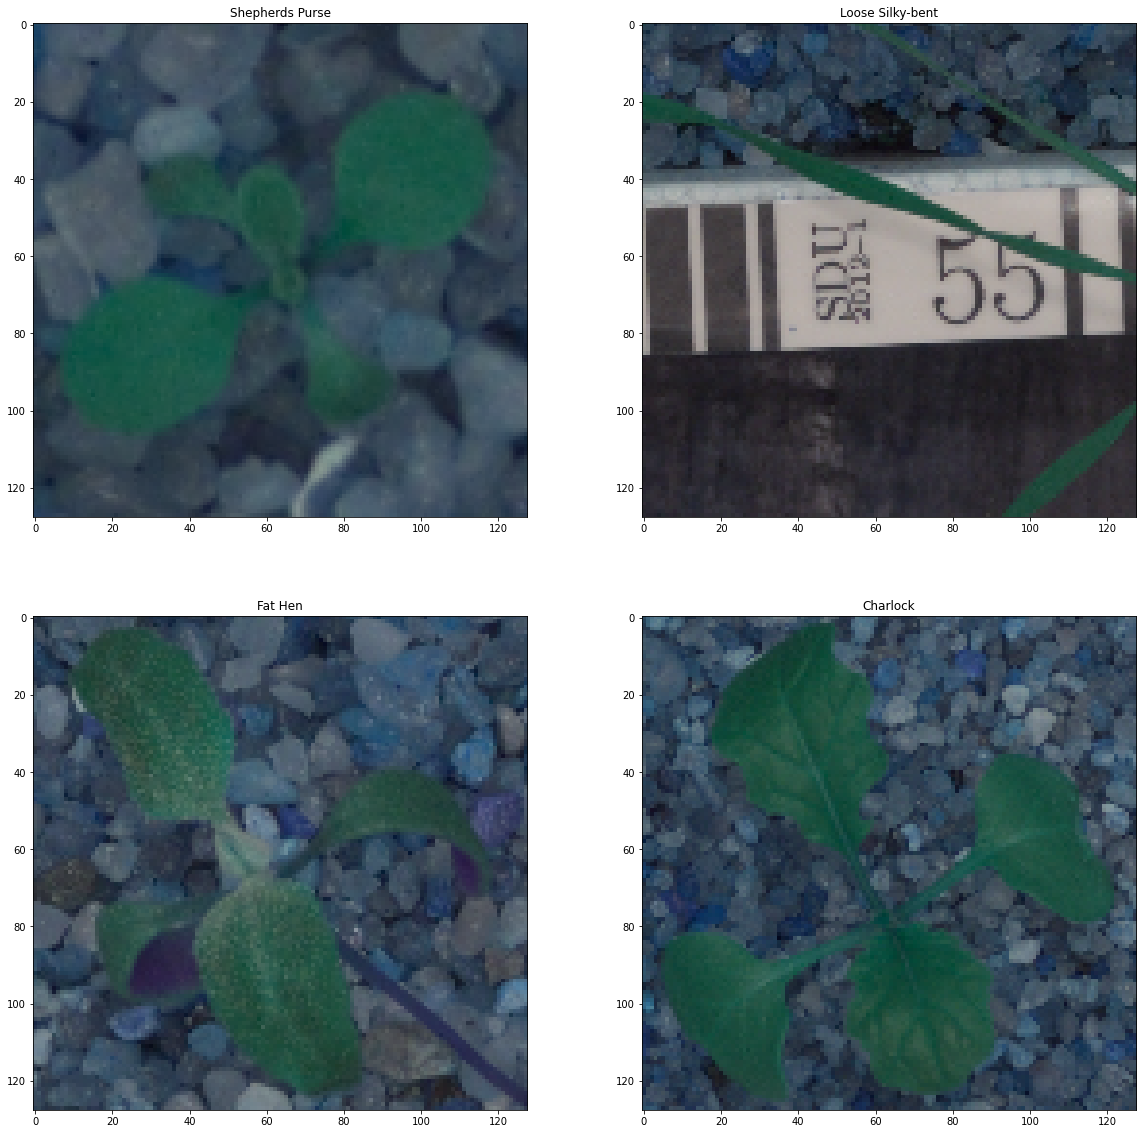

In [ ]:
# vizualizing some random images with the labels
print("image before pre-processing")
plt.figure(figsize=(20,20))
idx=[]
for i in range(4):
    index = randint(0, 4749)
    idx.append(index)
    plt.subplot(2,2,i+1)
    plt.imshow(image[index])
    plt.title(labels.iloc[index].values[0])    
plt.show()



After pre-processing


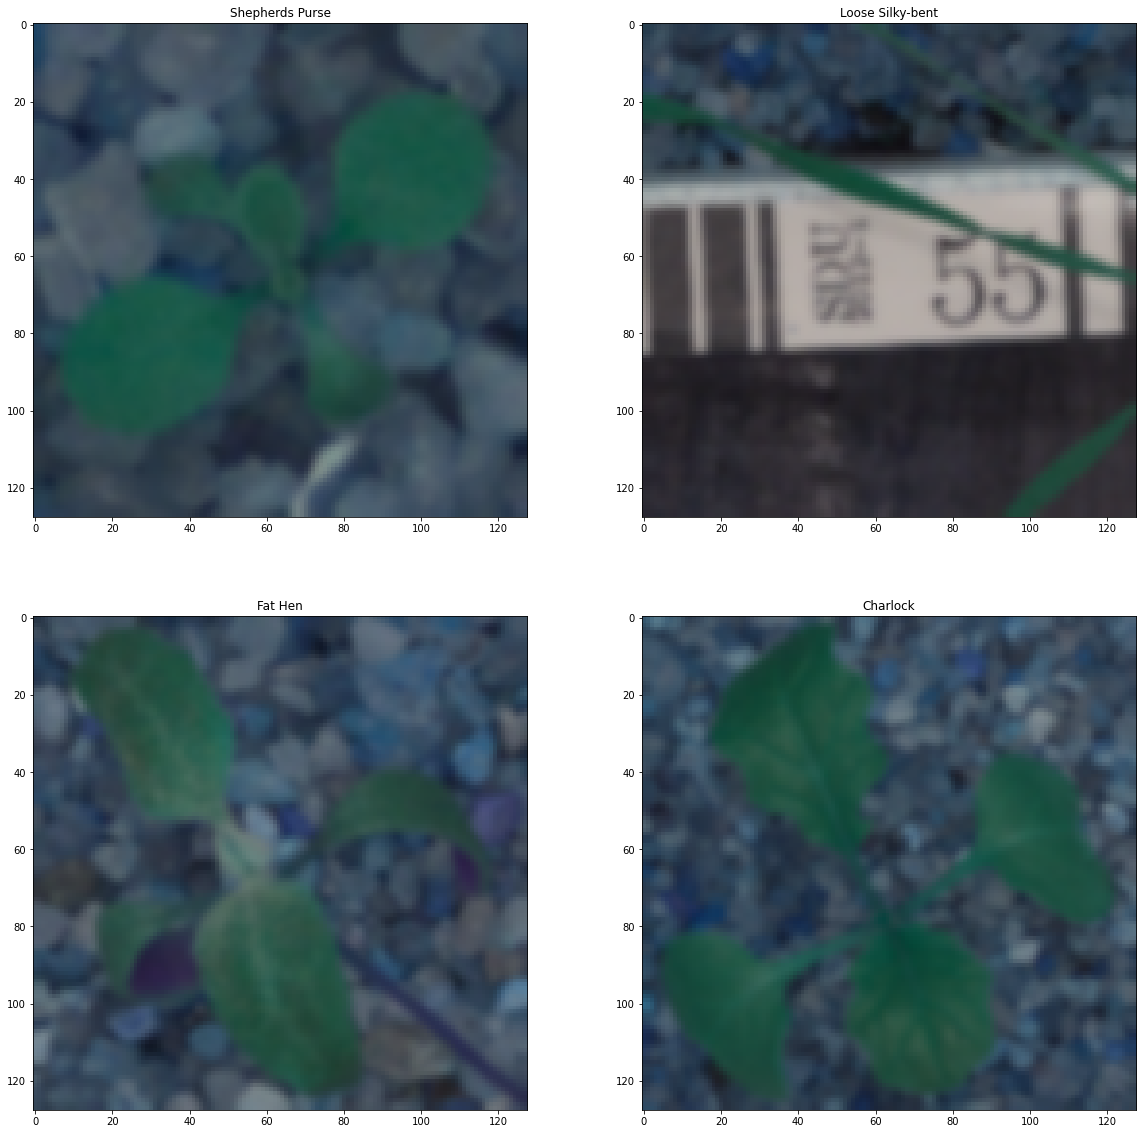

In [ ]:
# vizualizing some random images with the labels
print("After pre-processing")
plt.figure(figsize=(20,20))
for i, index in enumerate(idx):
    plt.subplot(2,2,i+1)
    plt.imshow(blurred_img[index], cmap = 'gray')
    plt.title(labels.iloc[index].values[0])    
plt.show()

# Let us process gray image - Gaussing and Normalization (pre and post)

Gausian/Normalization - Pre


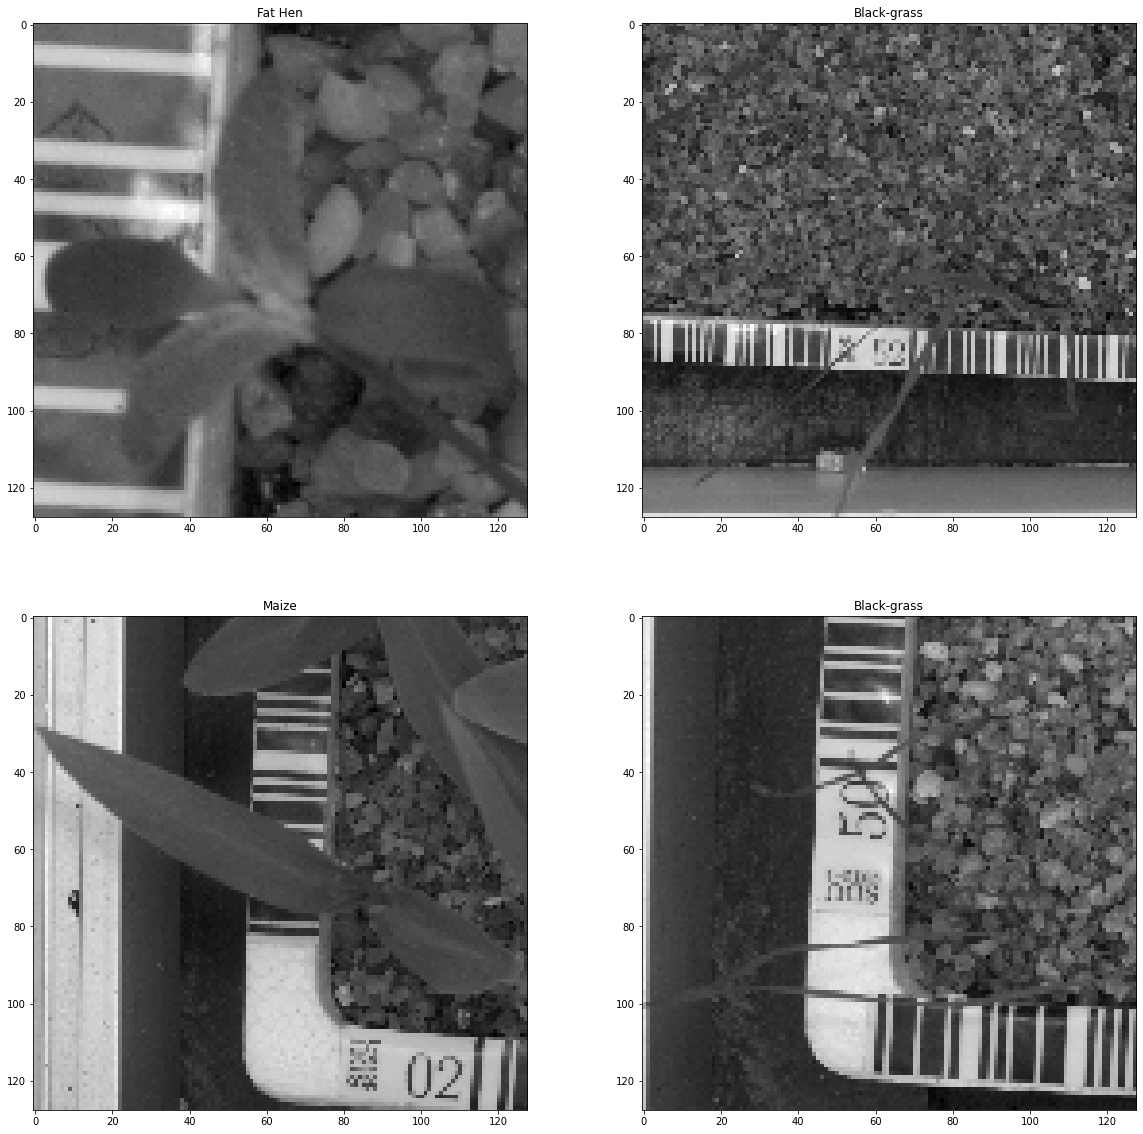

In [ ]:
# vizualizing some random Gray images with the labels
print("Gausian/Normalization - Pre")
plt.figure(figsize=(20,20))
arr=[]
for i in range(4):
    index = randint(0, 4749)
    arr.append(index)
    plt.subplot(2,2,i+1)
    plt.imshow(gray_img[index], cmap ='gray')
    plt.title(labels.iloc[index].values[0])    
plt.show()

Gaussian/Normalization - Post


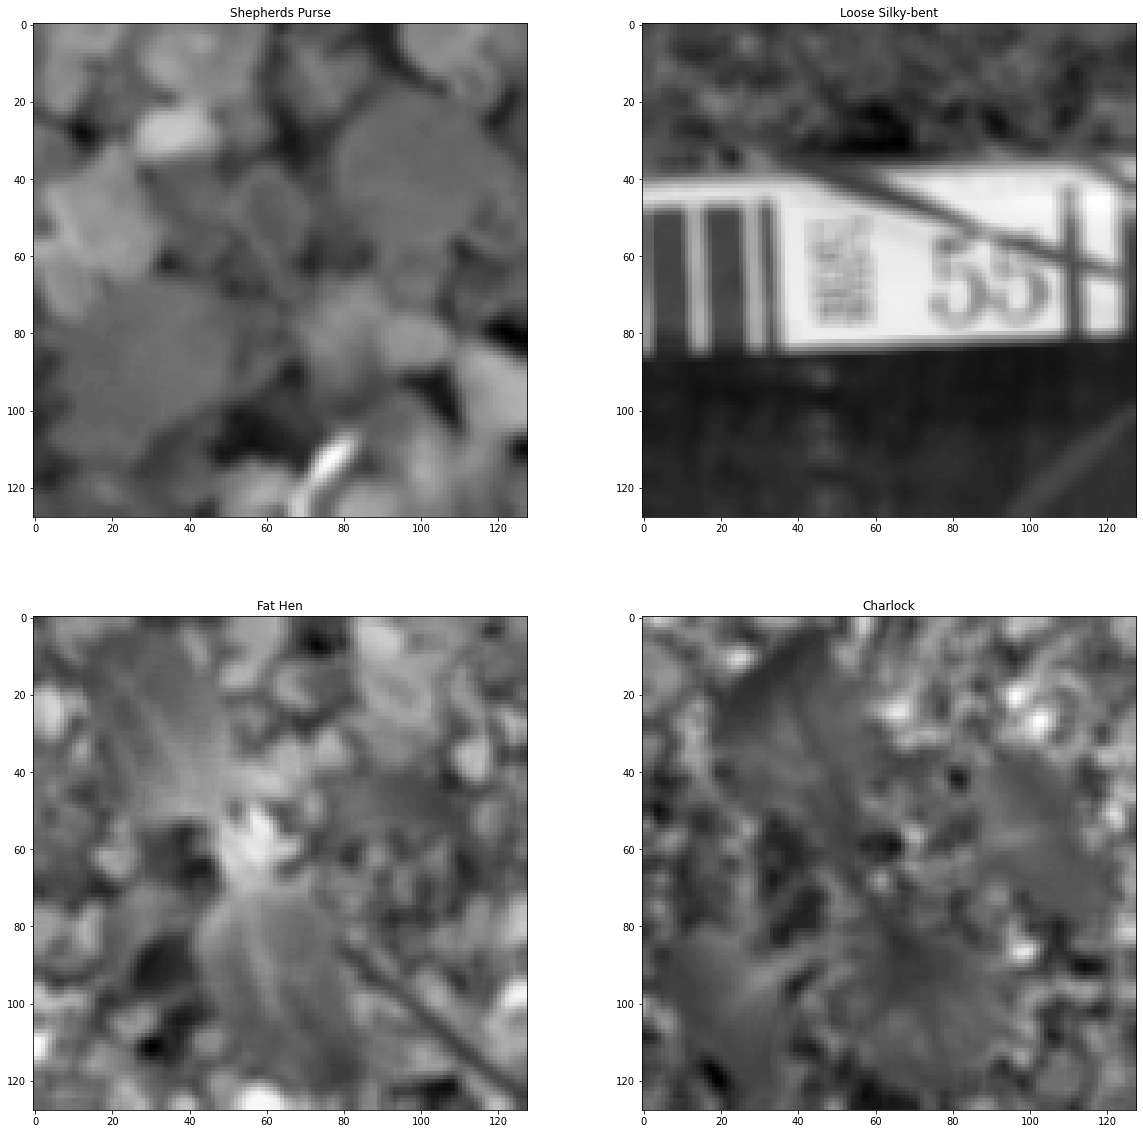

In [ ]:
# vizualizing some random images with the labels
print("Gaussian/Normalization - Post")
plt.figure(figsize=(20,20))
for i, index in enumerate(idx):
    plt.subplot(2,2,i+1)
    plt.imshow(blurred_gray_img[index], cmap = 'gray')
    plt.title(labels.iloc[index].values[0])    
plt.show()


# Training and Test data

In [ ]:
"""
Algo:
choose color blurred image
retain image as few plant images (from eda) are hard to distinguish in gray images

"""
i = 0
X_train = []
y_train = []

X_test = []
y_test = []

idx = np.random.permutation(len(image))
x,y = np.array(blurred_img_norm)[idx], np.array(labels['Label'])[idx] #taking the normalized blurred img as input


for images,label in zip(x, y):
    i+=1
    if i < len(image)*.7:
        X_train.append(images)
        y_train.append(label)
    else:
        X_test.append(images)
        y_test.append(label)
X_train= np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)

# image reshaping 
X_train = X_train.reshape(-1,128,128,3)
X_test = X_test.reshape(-1,128,128,3)

(3324, 128, 128, 3)
(1426, 128, 128, 3)


Visualize training images with labels


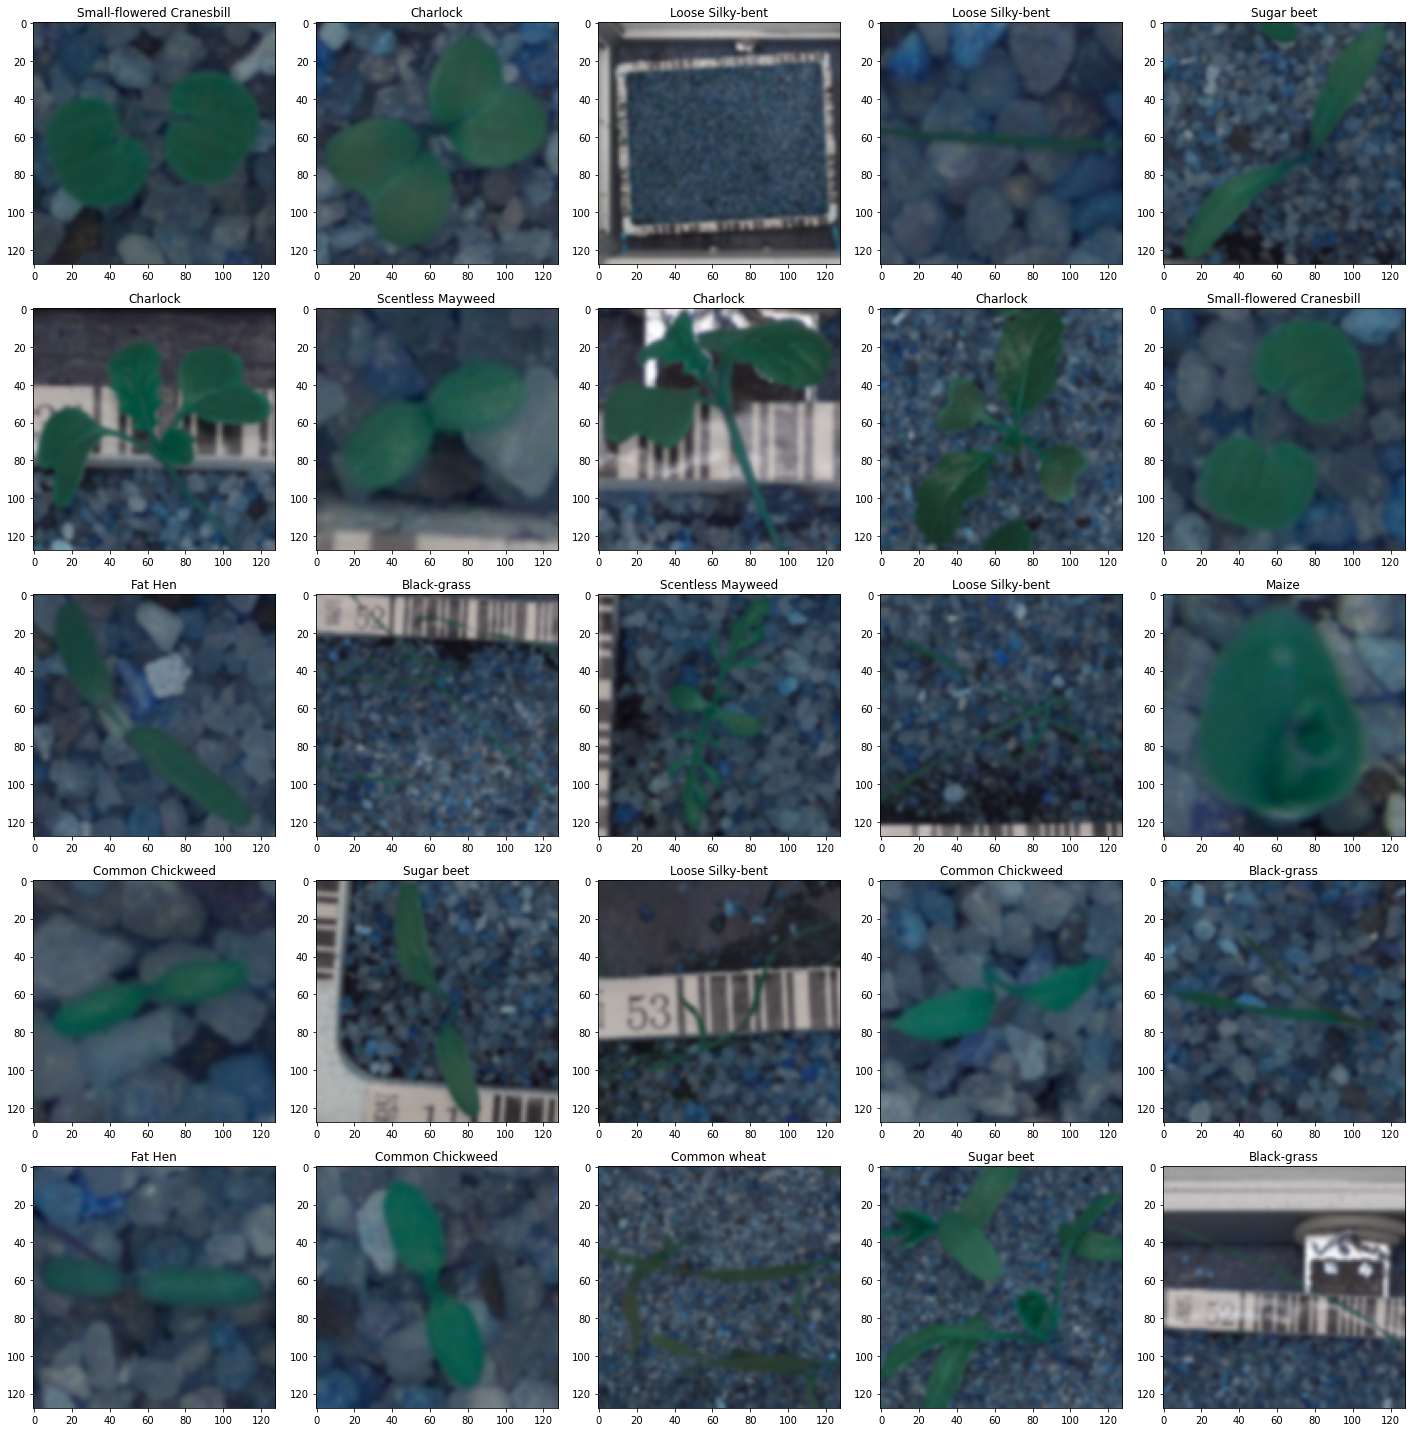

In [ ]:
# vizualizing training images with the labels
print("Visualize training images with labels")
plt.figure(figsize=(20,20))
for i in range(25):
    index = randint(0, 3324)
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[index])
    plt.title(y_train[index])
    plt.tight_layout()
plt.show()

## Label encoding

In [ ]:
# convert categorical seedlings into labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
categories = list(label_encoder.classes_)

## Hot Encoder

In [ ]:
encoded = to_categorical(y_train)
y_train_e=encoded
encoded_test = to_categorical(y_test)
y_test_e=encoded_test

## New shape of DS

In [ ]:
print(X_train.shape)
print(X_test.shape)

# image reshaping 
X_train = X_train.reshape(-1,128,128,3)
X_test = X_test.reshape(-1,128,128,3)

(3324, 128, 128, 3)
(1426, 128, 128, 3)


# Build the model

## CNN - relu activation and adam optmizzer

In [ ]:

# Template from MLS Session 2
# CNN relu activation / adam optimizer

in_shape= X_train.shape[1:]  #shape of training dataset for the input to model

model1 = Sequential()
#
y_train=np.array(y_train)
model1.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = in_shape))
model1.add(MaxPool2D(pool_size=(2,2)))

#
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#
model1.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#
model1.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


#
model1.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))


# 
model1.add(Flatten())
model1.add(Dense(1024, activation = "relu"))

model1.add(Dense(12, activation = "softmax"))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20) #early stopping
mc = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) #model saving

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [ ]:
# use adam optimizer

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999) #adam optimizer
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
epochs = 200  
batch_size = 64


history=model1.fit(X_train, 
          y_train_e,  #It expects integers because of the sparse_categorical_crossentropy loss function
          epochs=30, #number of iterations over the entire dataset to train on
          batch_size=64,validation_split=0.20,callbacks=[es,mc],use_multiprocessing=True)#number of samples per gradient update for training  


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 2.3887 - accuracy: 0.1760
Epoch 00001: val_accuracy improved from -inf to 0.24511, saving model to best_model1.h5
42/42 [==============================] - 13s 69ms/step - loss: 2.3887 - accuracy: 0.1760 - val_loss: 2.3024 - val_accuracy: 0.2451
Epoch 2/30
41/42 [============================>.] - ETA: 0s - loss: 1.7854 - accuracy: 0.3857
Epoch 00002: val_accuracy improved from 0.24511 to 0.43910, saving model to best_model1.h5
42/42 [==============================] - 2s 46ms/step - loss: 1.7833 - accuracy: 0.3855 - val_loss: 1.6682 - val_accuracy: 0.4391
Epoch 3/30
41/42 [============================>.] - ETA: 0s - loss: 1.4417 - accuracy: 0.5065
Epoch 00003: val_accuracy improved from 0.43910 to 0.50677, saving model to best_model1.h5
42/42 [==============================] - 2s 48ms/step - loss: 1.4395 - accuracy: 0.5073 - val_loss: 1.4355 - val_accuracy: 0.5068
Epoch 4/30
41/42 [============================>.] - ETA: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


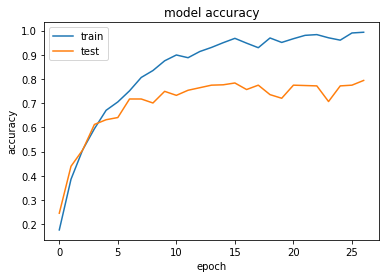

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#evaluation on test set
model1.evaluate(X_test,y_test_e)


45/45 [==============================] - 1s 12ms/step - loss: 1.3766 - accuracy: 0.7882


[1.37660551071167, 0.7882187962532043]

In [ ]:
# Test Prediction 
y_test_pred = model1.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)

In [ ]:
accuracy_score(np.array(y_test), y_test_pred_classes)

0.788218793828892

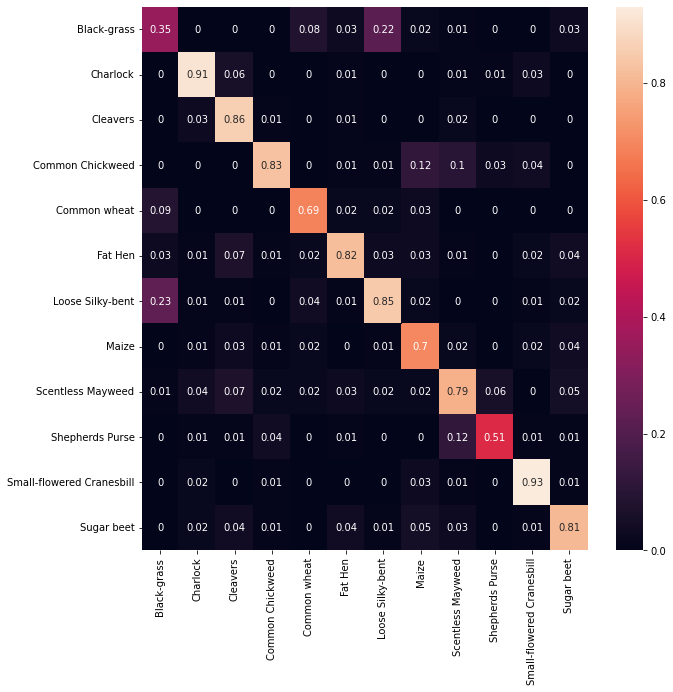

In [ ]:
matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = np.round(matrix/np.sum(matrix, axis=1), 2)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_n1,xticklabels=categories, yticklabels=categories, annot=True)



## Observations

- model overfit (high variance in accuracy)



# Improve model - add dropout 

In [ ]:
# Add dropout 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model2.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
in_shape= X_train.shape[1:]
model_dropout = Sequential()
#
y_train=np.array(y_train)
model_dropout.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = in_shape))
model_dropout.add(MaxPool2D(pool_size=(2,2)))
model_dropout.add(Dropout(0.25))
#
model_dropout.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_dropout.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_dropout.add(Dropout(0.25))
#
model_dropout.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model_dropout.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_dropout.add(Dropout(0.3))
#
model_dropout.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model_dropout.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_dropout.add(Dropout(0.3))

#
model_dropout.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model_dropout.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_dropout.add(Dropout(0.3))

# 
model_dropout.add(Flatten())
model_dropout.add(Dense(1024, activation = "relu"))
model_dropout.add(Dropout(0.5))
model_dropout.add(Dense(12, activation = "softmax"))


In [ ]:
model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 128)      

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_dropout.compile(optimizer = optimizer , loss = "categorical_crossentropy", 
                      metrics=["accuracy"])
epochs = 200  
batch_size = 64


history2=model_dropout.fit(X_train, 
          y_train_e,  
          epochs=30, 
          batch_size=64,validation_split=0.20,callbacks=[es,mc],
          use_multiprocessing=True)


Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 2.4389 - accuracy: 0.1324
Epoch 00001: val_accuracy improved from -inf to 0.12180, saving model to best_model2.h5
42/42 [==============================] - 226s 5s/step - loss: 2.4389 - accuracy: 0.1324 - val_loss: 2.4408 - val_accuracy: 0.1218
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 2.4192 - accuracy: 0.1369
Epoch 00002: val_accuracy did not improve from 0.12180
42/42 [==============================] - 219s 5s/step - loss: 2.4192 - accuracy: 0.1369 - val_loss: 2.4289 - val_accuracy: 0.1218
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 2.4158 - accuracy: 0.1376
Epoch 00003: val_accuracy did not improve from 0.12180
42/42 [==============================] - 227s 5s/step - loss: 2.4158 - accuracy: 0.1376 - val_loss: 2.4289 - val_accuracy: 0.1218
Epoch 4/30
42/42 [==============================] - ETA: 0s - loss: 2.3875 - accuracy: 0.1783
Epoch 00004: val_accuracy improved f

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


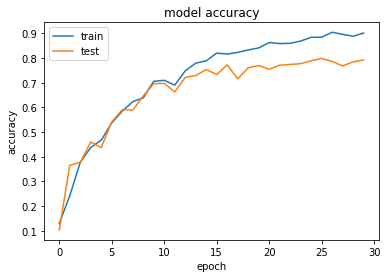

In [34]:
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
#evaluate on test set
model_dropout.evaluate(X_test,y_test_e)

45/45 [==============================] - 0s 10ms/step - loss: 0.6109 - accuracy: 0.8247


[0.6109350919723511, 0.8246844410896301]

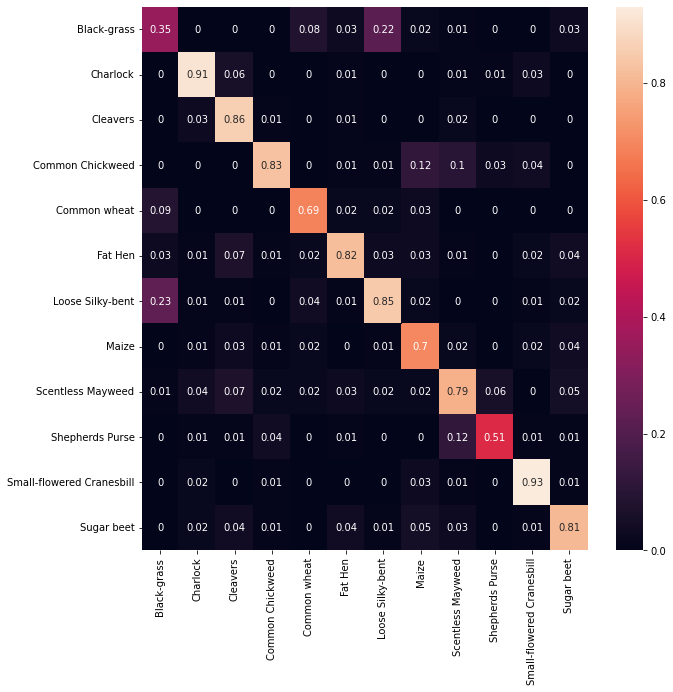

In [37]:
matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)
# Confusion matrix normalized per category true value
cf_matrix_n1 = np.round(matrix/np.sum(matrix, axis=1), 2)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_n1,xticklabels=categories, yticklabels=categories, annot=True)

## Observations
- Variance less, accurance increase



## Model improve - activation fn, leaky relu, adam optimizer

In [38]:
class conv_Layers:
   
  def __init__(self, nfilters, kernel_size, stride=1, 
               pool_size=2, leakyrelu_slope=0.1, dropc=0.0, bnorm=False):
    self.nfilters = nfilters
    self.kernel_size = kernel_size
    self.stride = stride
    self.pool_size = pool_size
    self.leakyrelu_slope = leakyrelu_slope
    self.dropfrac = dropc
    self.bnorm = bnorm
  
  def __call__(self, x):
    x = Conv2D(self.nfilters, kernel_size=self.kernel_size, 
               strides=self.stride, padding='same')(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0): 
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    x = MaxPool2D(self.pool_size)(x)
    return x

class dense_Layers:

  def __init__(self, nunits, leakyrelu_slope=0.1, dropd=0.0, bnorm=False):
    self.nunits = nunits
    self.leakyrelu_slope = leakyrelu_slope 
    self.dropfrac = dropd
    self.bnorm = bnorm

  def __call__(self, x):
    x = Dense(self.nunits)(x)
    x = LeakyReLU(self.leakyrelu_slope)(x)
    if (self.dropfrac > 0.0):
      x = Dropout(self.dropfrac)(x)
    if (self.bnorm):
      x = BatchNormalization()(x)
    return x


In [39]:


def LNmodel(in_shape, conv_filters, dense_filters, kernel_size, num_classes, lr,
            stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.0, dropd=0.0, bnorm=False):

  in_shape = X_train.shape[1:]
  i = Input(shape=in_shape)
  for ncl, nconvfilters in enumerate(conv_filters):
    if (ncl==0):
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(i)
    else:
      x = conv_Layers(nconvfilters, kernel_size,
                      stride, pool_size, leakyrelu_slope, dropc, bnorm)(x)

  x = Flatten()(x)

  for ndl, ndunits in enumerate(dense_filters):
    x = dense_Layers(ndunits, leakyrelu_slope, dropd, bnorm)(x)

  x = Dense(num_classes, activation='softmax')(x)

  ln_model  = Model(inputs=i, outputs=x)
  adam = optimizers.Adam(learning_rate=lr)
  ln_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
  return ln_model



In [40]:
lr = 0.001
kernelsize = 3
in_shape= X_train.shape[1:]
model = LNmodel(in_shape, [64,128,256], [1024,256], kernelsize, 12, lr,
                    stride=1, pool_size=2, leakyrelu_slope=0.1, dropc=0.25,
                    dropd=0.5, bnorm=False)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 dropout_6 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       73856     
                                                             

In [42]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model3.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history3 = model.fit(X_train, y_train_e, 
                                  validation_split=0.2,
                                  verbose=1, batch_size=64,
                                  shuffle=True, epochs=60,callbacks=[es,mc])

Epoch 1/60
42/42 [==============================] - ETA: 0s - loss: 2.4773 - accuracy: 0.2114
Epoch 00001: val_accuracy improved from -inf to 0.34436, saving model to best_model3.h5
42/42 [==============================] - 7s 148ms/step - loss: 2.4773 - accuracy: 0.2114 - val_loss: 2.0173 - val_accuracy: 0.3444
Epoch 2/60
41/42 [============================>.] - ETA: 0s - loss: 1.7590 - accuracy: 0.3979
Epoch 00002: val_accuracy did not improve from 0.34436
42/42 [==============================] - 3s 69ms/step - loss: 1.7563 - accuracy: 0.3975 - val_loss: 2.2957 - val_accuracy: 0.3188
Epoch 3/60
41/42 [============================>.] - ETA: 0s - loss: 1.4421 - accuracy: 0.4981
Epoch 00003: val_accuracy improved from 0.34436 to 0.35038, saving model to best_model3.h5
42/42 [==============================] - 5s 125ms/step - loss: 1.4391 - accuracy: 0.4983 - val_loss: 2.1895 - val_accuracy: 0.3504
Epoch 4/60
41/42 [============================>.] - ETA: 0s - loss: 1.1900 - accuracy: 0.588

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


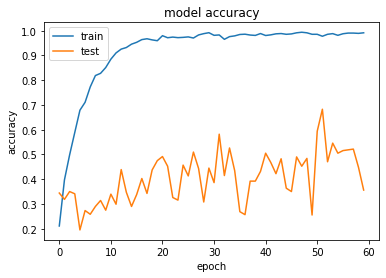

In [43]:
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# Test Prediction 
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_pred_prob = np.max(y_test_pred, axis=1)

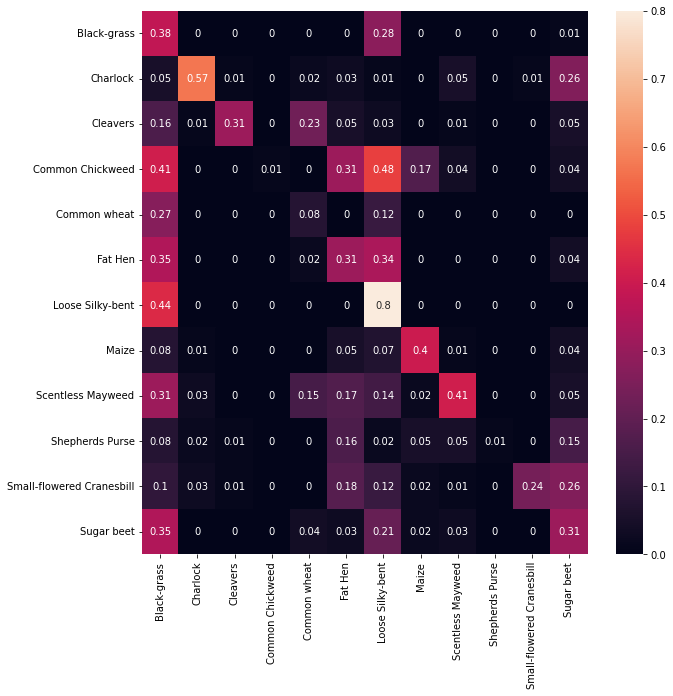

In [46]:
matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)

# Confusion matrix normalized per category true value
cf_matrix_n1 = np.round(matrix/np.sum(matrix, axis=1), 2)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix_n1,xticklabels=categories, yticklabels=categories, annot=True)

## Categories

- in this model, accuracy is better
- this model performs c.f to the other 2 models



# Eval the 3 models

## Confusion matrix

In [55]:
#helper function
def confusion_matrix_plot(model):
  y_test_pred = model.predict(X_test)
  y_test_pred_classes = np.argmax(y_test_pred, axis=1)
  y_test_pred_prob = np.max(y_test_pred, axis=1)
  cf_matrix = confusion_matrix(np.array(y_test), y_test_pred_classes)
  # Confusion matrix normalized per category true value
  cf_matrix_n1 = np.round(cf_matrix/np.sum(cf_matrix, axis=1), 2)
  plt.figure(figsize=(10,10))
  sns.heatmap(cf_matrix_n1,xticklabels=categories, yticklabels=categories, annot=True)



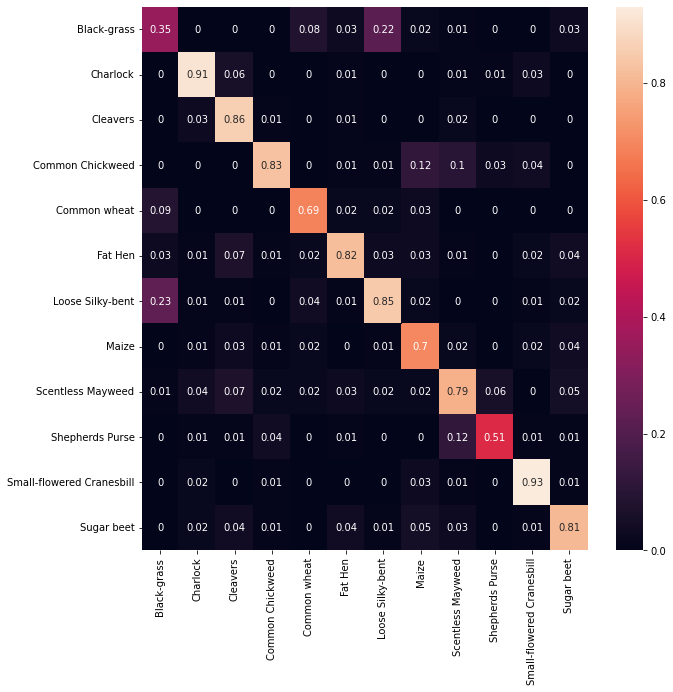

In [56]:
confusion_matrix_plot(model1)

In [51]:
# first model evaluation on test set
model1.evaluate(X_test,y_test_e)

45/45 [==============================] - 0s 9ms/step - loss: 1.3766 - accuracy: 0.7882


[1.37660551071167, 0.7882187962532043]

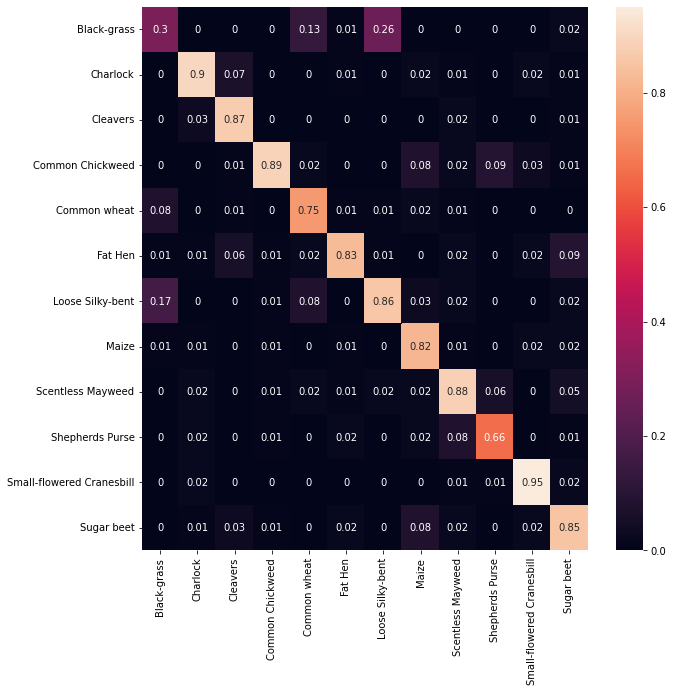

In [57]:
confusion_matrix_plot(model_dropout)

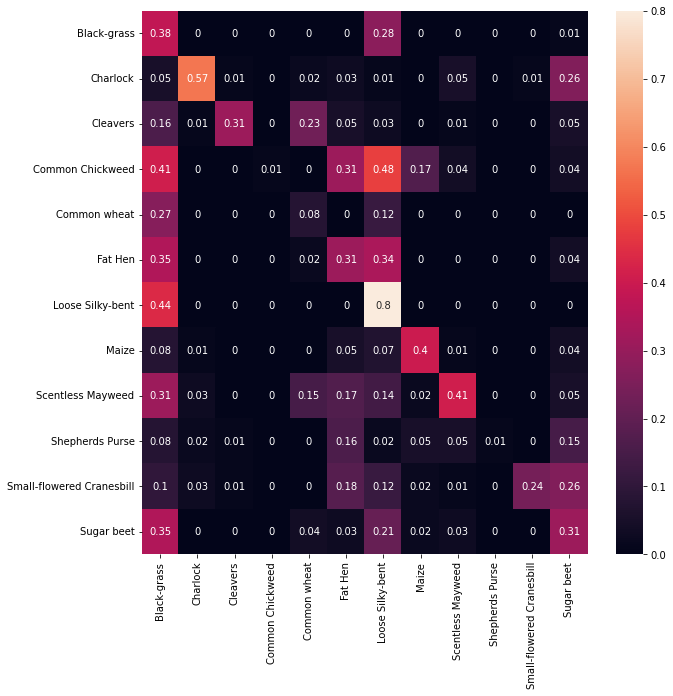

In [59]:
# CM for 2nd model
confusion_matrix_plot(model)

In [50]:
# 2nd model evaluation on test set
model_dropout.evaluate(X_test,y_test_e)

45/45 [==============================] - 0s 10ms/step - loss: 0.6109 - accuracy: 0.8247


[0.6109350919723511, 0.8246844410896301]

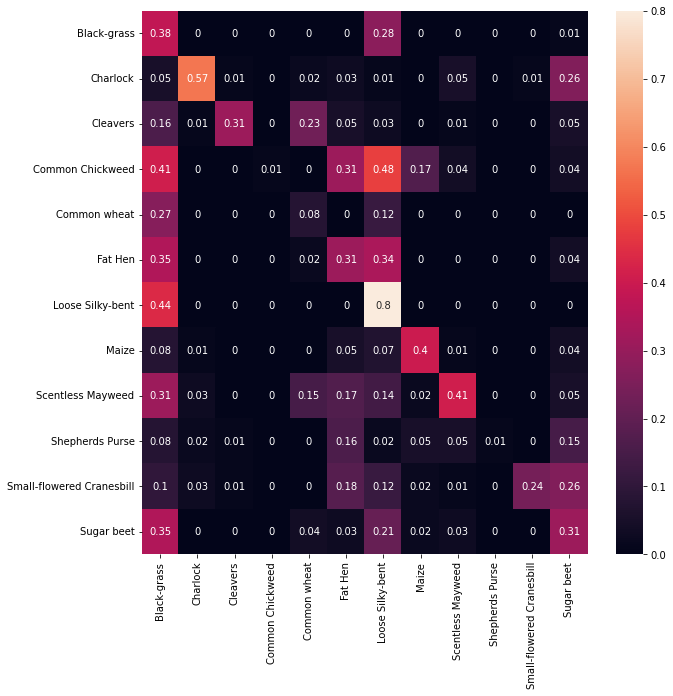

In [58]:
# CM for 3rd model
confusion_matrix_plot(model)

In [49]:
#3rd model evaluation on test set
model.evaluate(X_test,y_test_e)

45/45 [==============================] - 1s 13ms/step - loss: 7.7888 - accuracy: 0.3485


[7.78879451751709, 0.34852734208106995]

In [53]:
comparison_frame = pd.DataFrame({'Model':['first_model : CNN model','2nd_model : CNN Model (Dropout Included)',
                                          '3rd_model - Leaky Relu Activation and Adam Optimizer'], 'Training Accuracy':[0.992,0.905,0.986], 'Validation Accuray':[0.784,0.792,0.612], 'Test Set Accuray':[0.772,0.807,0.597], 'Remarks':['High Variance, Overfitted on Training Set','Improved and Reqularized Model','High Variance and Low Accuracy']}) 
comparison_frame


Model  ...                                    Remarks
0                            first_model : CNN model  ...  High Variance, Overfitted on Training Set
1           2nd_model : CNN Model (Dropout Included)  ...             Improved and Reqularized Model
2  3rd_model - Leaky Relu Activation and Adam Opt...  ...             High Variance and Low Accuracy

[3 rows x 5 columns]

## Conclusions
- 2nd model performs the best on accuracy

# Predictions - pictorially

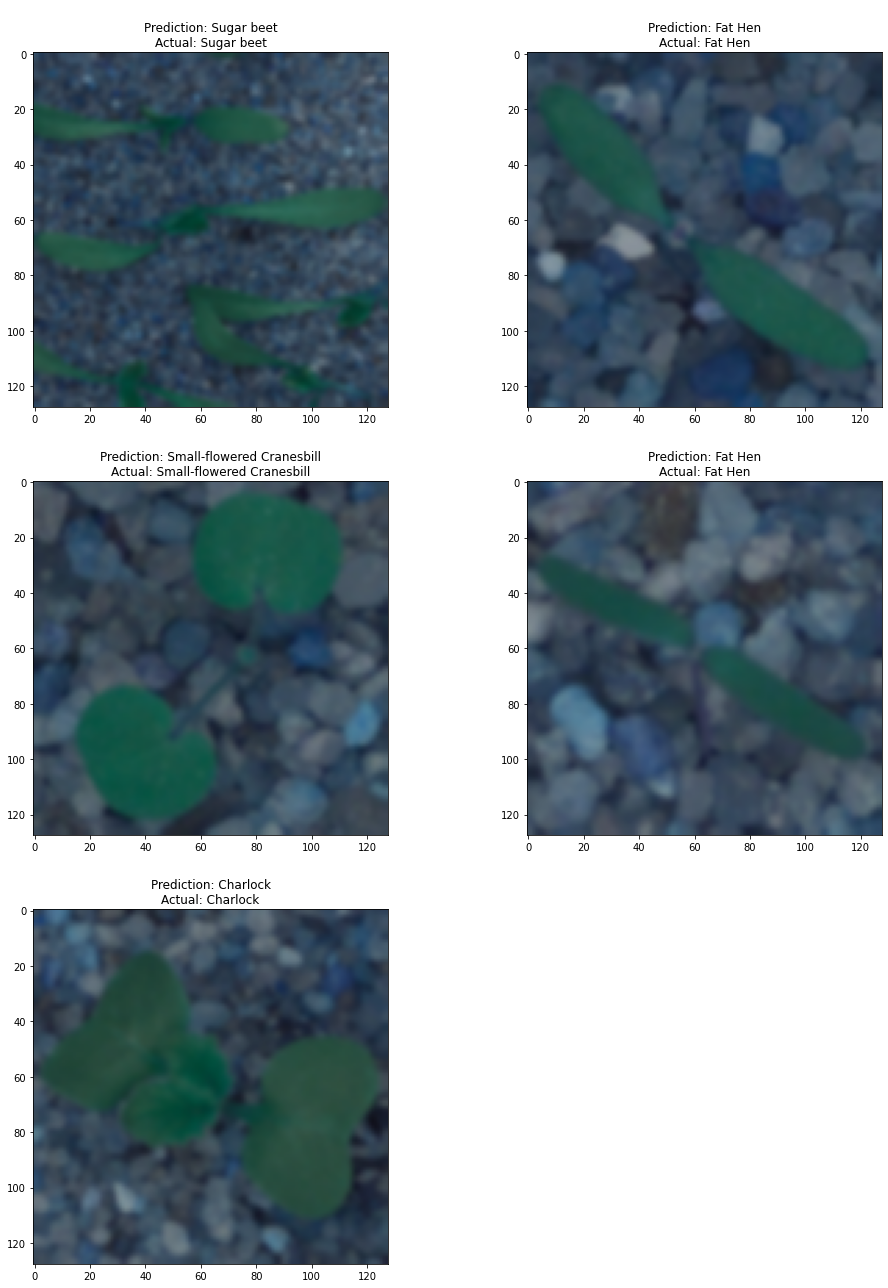

In [60]:
# Model2 to see the prediction
chk = [2,3,33,36,59]
plt.figure(figsize=(15,18))
for i,n  in enumerate(chk):
    plt.subplot(3,2,i+1)
    plt.imshow(X_test[n]) #plant seedlings
    ttl = '\n'+'Prediction: ' + str(categories[np.argmax(model_dropout.predict(X_test)[n])]) + '\n'+'Actual: ' + str(categories[y_test[n]])
    plt.title(ttl) 
    plt.tight_layout()   
plt.show()



## Observations
- 2nd model predicted all classifications correctly

# Final notes
- We have accuracy of 80% with 2nd model
- In sample validation, it was successful